# Inductive representation learning using GraphSAGE on the Pubmed-Diabetes citation network 

This notebook demonstrates inductive representation learning using the GraphSAGE [1] algorithm applied to inferring the subject of papers in a citation network.

To demonstrate inductive representation learning, we train a GraphSAGE model on a subgraph of the Pubmed-Diabetes citation network dataset and then use the trained model to predict the subject of nodes that were excluded from the subgraph used for model training. 

We remove 20 percent of the network nodes (including all the edges from these nodes to any other nodes in the network) and then train a GraphSAGE model using this network comprised of the remaining 80 percent of nodes. For training, we only use 5 percent of labeled data.

After training the model, we use it to predict the labels, i.e., paper subjects, of the nodes originally held out after re-inserting them in the network. For prediction, we do not retrain the GraphSAGE model.

**References**

[1] Inductive Representation Learning on Large Graphs. W.L. Hamilton, R. Ying, and J. Leskovec arXiv:1706.02216 [cs.SI], 2017.

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import itertools
import os

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import stellargraph as sg
from stellargraph import globalvar
from stellargraph.mapper import GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE

from keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def load_pubmed(data_dir):
    edgelist = pd.read_table(os.path.join(data_dir, 'Pubmed-Diabetes.DIRECTED.cites.tab'), 
                             skiprows=2, 
                             header=None )
    edgelist.drop(columns=[0,2], inplace=True)
    edgelist.columns = ['source', 'target']
    # delete unneccessary prefix 
    edgelist['source'] = edgelist['source'].map(lambda x: x.lstrip('paper:')) 
    edgelist['target'] = edgelist['target'].map(lambda x: x.lstrip('paper:'))
    edgelist["label"] = "cites"  # set the edge type
    
    # Load the graph from the edgelist
    g_nx = nx.from_pandas_edgelist(edgelist, edge_attr="label")

    # Load the features and subject for each node in the graph
    nodes_as_dict = []
    with open(os.path.join(os.path.expanduser(data_dir), 
                           "Pubmed-Diabetes.NODE.paper.tab")) as fp:
        for line in itertools.islice(fp, 2, None):
            line_res = line.split("\t")
            pid = line_res[0]
            feat_name = ['pid'] + [l.split("=")[0] for l in line_res[1:]][:-1] # delete summary
            feat_value = [l.split("=")[1] for l in line_res[1:]][:-1] # delete summary
            feat_value = [pid] + [ float(x) for x in feat_value ] # change to numeric from str
            row = dict(zip(feat_name, feat_value))
            nodes_as_dict.append(row)

    # Create a Pandas dataframe holding the node data        
    node_data = pd.DataFrame(nodes_as_dict)
    node_data.fillna(0, inplace=True)
    node_data['label'] = node_data['label'].astype(int)
    node_data['label'] = node_data['label'].astype(str)
    
    node_data.index = node_data['pid']
    node_data.drop(columns=['pid'], inplace=True)
    node_data.head()
    
    for nid in node_data.index:
        g_nx.node[nid][globalvar.TYPE_ATTR_NAME] = "paper"  # specify node type
    
    feature_names = list(node_data.columns)
    feature_names.remove("label")

    return g_nx, node_data, feature_names

In [3]:
def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='best')
        plt.show()

### Loading the dataset

**Downloading the PubMed-Diabetes dataset:**

The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/Pubmed-Diabetes.tgz

The following is the description of the dataset:

>The Pubmed Diabetes dataset consists of 19717 scientific publications from PubMed database pertaining to diabetes classified into one of three classes. The citation network consists of 44338 links. Each publication in the dataset is described by a TF/IDF weighted word vector from a dictionary which consists of 500 unique words.

Download and unzip the Pubmed-Diabetes.tgz file to a location on your computer.

Set the data_dir variable to point to the location of the processed dataset.

In [4]:
data_dir = os.path.expanduser("~/data/pubmed/Pubmed-Diabetes/data")

First, we are going to load the full graph and the corresponding node features and feature names

In [5]:
g_nx, node_data, feature_names = load_pubmed(data_dir)

We aim to train a graph-ML model that will predict the "label" attribute on the nodes. These labels are one of 3 categories:

In [6]:
set(node_data["label"])

{'1', '2', '3'}

We are going to **remove 20 percent of the nodes from the graph**. Then, we are going to train a GraphSAGE model on the reduced graph with the remaining 80 percent of the nodes from the original graph. Later, we are going to re-introduce the removed nodes and try to predict their labels without re-training the GraphSAGE model.

In [7]:
node_data.shape

(19717, 501)

In [8]:
node_data_sampled = node_data.sample(frac=0.8, replace=False, random_state=101)

**node_data_sampled** is a Pandas dataframe that holds the node features and node IDs (the dataframe index) of the subgraph we are going to use for training the GraphSAGE model.

In [9]:
node_data_sampled.shape

(15774, 501)

Now, we are going to extract the subgraph corresponding to the sampled nodes.

In [10]:
g_nx_sampled = g_nx.subgraph(node_data_sampled.index).copy()

In [11]:
print("Original graph number of nodes {} and edges {}".format(g_nx.number_of_nodes(), 
                                                              g_nx.number_of_edges()))
print("Sampled graph number of nodes {} and edges {}".format(g_nx_sampled.number_of_nodes(), 
                                                             g_nx_sampled.number_of_edges()))

Original graph number of nodes 19717 and edges 44327
Sampled graph number of nodes 15774 and edges 28845


Note above that both the number of nodes and edge have been reduced after removing 20 percent of the nodes in the original graph.

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for testing. We'll use scikit-learn again to do this.

We are going to use 5 percent of the data for training and of the remaining nodes, we are going to use 20 percent as the validation set. The other 80 percent we can treat as a test set.

In [12]:
train_data, test_data = model_selection.train_test_split(node_data_sampled, 
                                                         train_size=0.05, 
                                                         test_size=None, 
                                                         stratify=node_data_sampled["label"], 
                                                         random_state=42)
val_data, test_data = model_selection.train_test_split(test_data, 
                                                       train_size=0.2, 
                                                       test_size=None, 
                                                       stratify=test_data["label"],
                                                       random_state=100)

Note using stratified sampling gives the following counts:

In [13]:
from collections import Counter
Counter(train_data['label'])

Counter({'1': 164, '3': 310, '2': 314})

The training set has class imbalance that might need to be compensated, e.g., via using a weighted cross-entropy loss in model training, with class weights inversely proportional to class support. However, we will ignore the class imbalance in this example, for simplicity.

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training.

In [14]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)

train_targets = target_encoding.fit_transform(train_data[['label']].to_dict('records'))
val_targets = target_encoding.transform(val_data[['label']].to_dict('records'))
test_targets = target_encoding.transform(test_data[['label']].to_dict('records'))

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input.


In [15]:
node_features_sampled = node_data_sampled[feature_names]

In [16]:
node_features_sampled.head()

,w-0,w-0001,w-001,w-01,w-02,w-05,w-1,w-10,w-100,w-11,...,w-vitro,w-vivo,w-vs,w-week,w-weight,w-wherea,w-women,w-x,w-year,w-young
pid,,,,,,,,,,,,,,,,,,,,,
16221917,0.000000,0.000000,0.000000,0.0,0.0,0.02348,0.000000,0.000000,0.0,0.026065,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.034684,0.000000
18591404,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.030669,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.156042,0.0,0.082903,0.049766
16424231,0.000000,0.000000,0.000000,0.0,0.0,0.00000,0.024495,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
9925350,0.022750,0.000000,0.044057,0.0,0.0,0.00000,0.004523,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.00000,0.015917,0.0,0.039451,0.0,0.000000,0.022019
17448371,0.028643,0.022141,0.000000,0.0,0.0,0.00000,0.009112,0.011677,0.0,0.000000,...,0.0,0.0,0.0,0.03022,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [17]:
# sanity check to make sure that the node labels are not included in the node features
'label' in node_features_sampled  

False

## Creating the GraphSAGE model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

In [18]:
G = sg.StellarGraph(g_nx_sampled, node_features=node_features_sampled)

In [19]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 15774, Edges: 28845

 Node types:
  paper: [15774]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [28845]



To feed data from the graph to the Keras model we need a mapper. The mappers are specialized to the model and the learning task so we choose the `GraphSAGENodeMapper` as we are predicting node attributes with a GraphSAGE model.

We need two other parameters, the `batch_size` to use for training and the number of nodes to sample at each level of the model. Here we choose a two-level model with 10 nodes sampled in the first layer, and 5 in the second.

In [20]:
batch_size = 50; num_samples = [10, 10]

A `GraphSAGENodeGenerator` object is required to send the node features in sampled subgraphs to Keras

In [21]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

For training we map only the training nodes returned from our splitter and the target values. The `shuffle=True` argument is given to the `flow` method to improve training.

In [22]:
train_gen = generator.flow(train_data.index, train_targets, shuffle=True)
val_gen = generator.flow(val_data.index, val_targets, shuffle=True)

Now we can specify our machine learning model, we need a few more parameters for this:

 * the `layer_sizes` is a list of hidden feature sizes of each layer in the model. In this example we use 32-dimensional hidden node features at each layer.
 * The `bias` and `dropout` are internal parameters of the model. 

In [23]:
graphsage_model = GraphSAGE(
    layer_sizes=[32, 32],
    generator=train_gen,
    bias=True,
    dropout=0.5,
)

Now we create a model to predict the 3 categories using Keras softmax layers. Note that we need to use the `G.get_target_size` method to find the number of categories in the data.

In [24]:
x_inp, x_out = graphsage_model.default_model(flatten_output=True)
prediction = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [25]:
prediction.shape

TensorShape([Dimension(None), Dimension(3)])

### Training the model

Now let's create the actual Keras model with the graph inputs `x_inp` provided by the `graph_model` and outputs being the predictions from the softmax layer

In [26]:
model = Model(inputs=x_inp, outputs=prediction)
model.compile(
    optimizer=optimizers.Adam(lr=0.005),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the test set (we need to create another generator over the test data for this)

In [27]:
test_gen = generator.flow(test_data.index, test_targets)

In [28]:
history = model.fit_generator(
    train_gen,
    epochs=15,
    validation_data=val_gen,
    verbose=0,
    shuffle=False
)

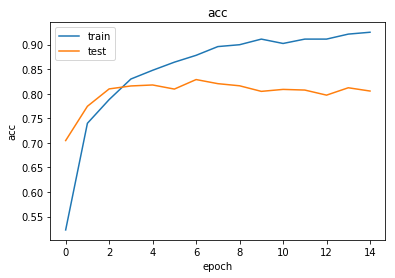

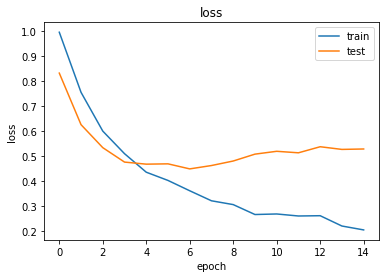

In [29]:
plot_history(history)

Now we have trained the model we can evaluate on the test set.

In [30]:
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 0.5194
	acc: 0.8197


### Making predictions with the model

We want to use the trained model to predict the nodes we put aside earlier. For this, we must create a new StellarGraph object and a new node generator.

In [31]:
node_features = node_data[feature_names]

In [32]:
node_data[feature_names].shape

(19717, 500)

The graph **G** we are going to create next is a `StellarGraph` object representing the complete citation network.

In [33]:
G = sg.StellarGraph(g_nx, node_features=node_features)

In [34]:
generator = GraphSAGENodeGenerator(G, batch_size, num_samples)

Now let's get the predictions themselves for all nodes in the held out set. We are going to use another mapper.

In [35]:
node_data_hold_out = pd.concat([node_data_sampled,node_data]).drop_duplicates(keep=False)

In [36]:
node_features_hold_out = node_data_hold_out[feature_names]

In [37]:
node_data_hold_out.shape

(3941, 501)

In [38]:
hold_out_targets = target_encoding.transform(node_data_hold_out[['label']].to_dict('records'))

In [39]:
hold_out_nodes = node_data_hold_out.index
hold_out_mapper = generator.flow(hold_out_nodes, hold_out_targets)
hold_out_predictions = model.predict_generator(hold_out_mapper)

These predictions will be the output of the softmax layer, so to get final categories we'll use the `inverse_transform` method of our target attribute specifcation to turn these values back to the original categories

In [40]:
hold_out_predictions = target_encoding.inverse_transform(hold_out_predictions)

In [41]:
len(hold_out_predictions)

3941

Let's have a look at a few:

In [42]:
results = pd.DataFrame(hold_out_predictions, index=hold_out_nodes).idxmax(axis=1)
df = pd.DataFrame({"Predicted": results, "True": node_data_hold_out['label']})
df.head(10)

,Predicted,True
pid,,
2344352,label=1,1
2684155,label=1,1
10960717,label=1,1
15723700,label=2,3
16118269,label=1,1
11756346,label=3,3
11731221,label=3,3
9356032,label=3,3
16219016,label=3,3


In [43]:
hold_out_metrics = model.evaluate_generator(hold_out_mapper)
print("\nHold Out Set Metrics:")
for name, val in zip(model.metrics_names, hold_out_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Hold Out Set Metrics:
	loss: 0.4971
	acc: 0.8290


## Node embeddings for held out nodes

Evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

The GraphSAGE embeddings are the output of the GraphSAGE layers, namely the `x_out` variable. Let's create a new model with the same inputs as we used previously `x_inp` but now the output is the embeddings rather than the predicted class. Additionally note that the weights trained previously are kept in the new model.

In [44]:
embedding_model = Model(inputs=x_inp, outputs=x_out)

In [45]:
emb = embedding_model.predict_generator(hold_out_mapper)
emb.shape

(3941, 32)

Project the embeddings to 2d using either TSNE or PCA transform, and visualise, coloring nodes by their subject label

In [46]:
X = emb
y = np.argmax(target_encoding.transform(node_data_hold_out[["label"]].to_dict('records')), 
              axis=1)

In [47]:
if X.shape[1] > 2:
    transform = TSNE #PCA 

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_data_hold_out.index)
    emb_transformed['label'] = y
else:
    emb_transformed = pd.DataFrame(X, index=node_data_hold_out.index)
    emb_transformed = emb_transformed.rename(columns = {'0':0, '1':1})
    emb_transformed['label'] = y

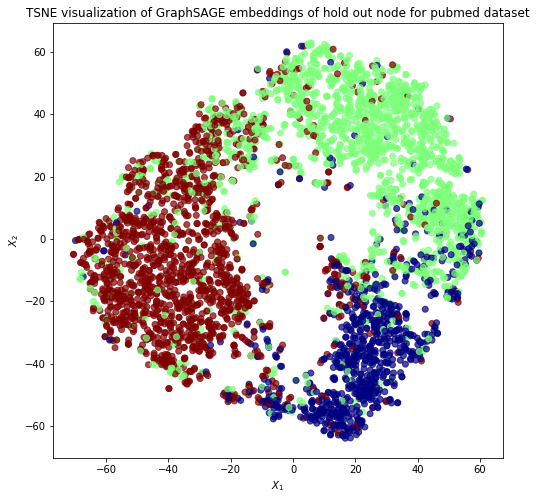

In [48]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(emb_transformed[0], emb_transformed[1], c=emb_transformed['label'].astype("category"), 
            cmap="jet", alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title('{} visualization of GraphSAGE embeddings of hold out node for pubmed dataset'.format(transform.__name__))
plt.show()

This notebook demonstrated inductive representation learning using the GraphSAGE algorithm.